In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
# Semilla aleatoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-1.7194579;;], weight_hh = Float32[1.174417;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

6.2632223f9

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 5.0130447e9


Época 2 | coste = 4.046983e9
Época 3 | coste = 3.3034327e9
Época 4 | coste = 2.7312077e9
Época 5 | coste = 2.2893059e9
Época 6 | coste = 1.94581e9
Época 7 | coste = 1.6764061e9
Época 8 | coste = 1.4628404e9
Época 9 | coste = 1.2915259e9
Época 10 | coste = 1.1523862e9
Época 11 | coste = 1.0379493e9
Época 12 | coste = 9.4265696e8
Época 13 | coste = 8.623539e8
Época 14 | coste = 7.9391226e8
Época 15 | coste = 7.349589e8
Época 16 | coste = 6.836777e8
Época 17 | coste = 6.386652e8
Época 18 | coste = 5.9882643e8
Época 19 | coste = 5.632986e8
Época 20 | coste = 5.313949e8
Época 21 | coste = 5.0256346e8
Época 22 | coste = 4.7635606e8
Época 23 | coste = 4.5240582e8
Época 24 | coste = 4.3040934e8
Época 25 | coste = 4.101142e8
Época 26 | coste = 3.913082e8
Época 27 | coste = 3.7381197e8
Época 28 | coste = 3.5747312e8
Época 29 | coste = 3.4216106e8
Época 30 | coste = 3.277637e8
Época 31 | coste = 3.141841e8
Época 32 | coste = 3.0133814e8
Época 33 | coste = 2.891527e8
Época 34 | coste = 2.77564e8


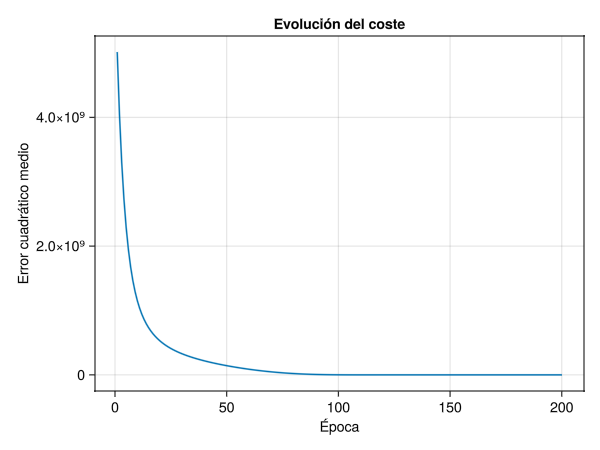

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 831997.2
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32[1.662782;;]
Pesos del estado de la red neuronal:Float32[-0.04483252;;]


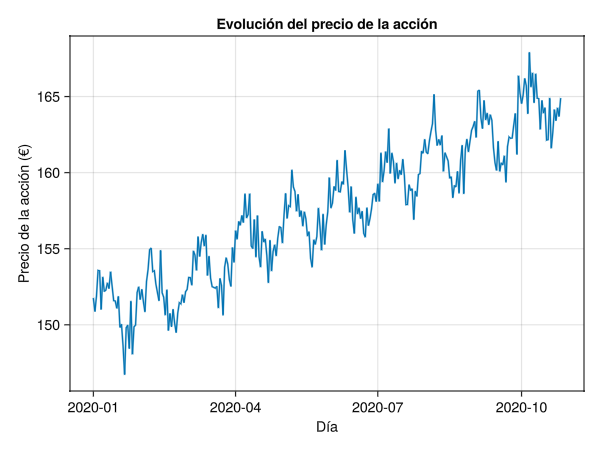

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(RNNCell(1 => 32); return_sequence = false),
    Dense(32 => 1)
)

rng = Random.default_rng()
# Semilla aletoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.30396008; 0.20760956; … ; -0.24947801; 0.095708035;;], weight_hh = Float32[-0.60596937 0.23632404 … -0.38938454 -0.6061492; 0.20912634 -0.1782639 … 0.16347872 0.3233644; … ; 0.12737364 0.26083985 … -0.07924062 -0.10240463; -0.41276667 -0.3120628 … -0.813448 -0.26750743], bias_ih = Float32[0.02674363, 0.42782104, 0.28144464, 0.34552068, 0.07392732, -0.600979, -0.055570092, 0.16641076, -0.17598884, 0.0963345  …  -0.61669946, 0.109181814, -0.06144221, -0.25843242, -0.4744732, 0.18614927, -0.27259025, -0.17347682, 0.20113508, 0.31891534], bias_hh = Float32[0.15857771, 0.015557139, 0.31689078, 0.01625859, -1.0146395, -0.20444514, 0.11716063, -0.1163518, -0.48315334, -0.5321763  …  -0.22002587, -0.52671355, 0.24541856, -0.25204748, 0.05252987, 0.35187724, -0.11285563, 0.3978162, 0.42272422, -0.578097]), layer_2 = (weight = Float32[-0.18454093 0.0010057642 … -0.24677686 -0.075592406], bias = Float32[-0.008240868])), (layer_1 = (rng = TaskLocalRNG(),), layer

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

7.114846f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 300
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 4.2990303


Época 2 | coste = 2.9647508
Época 3 | coste = 1.8690952
Época 4 | coste = 1.1508781
Época 5 | coste = 0.7507209
Época 6 | coste = 0.5535714
Época 7 | coste = 0.5515878


Época 8 | coste = 0.6515743
Época 9 | coste = 0.7974623
Época 10 | coste = 0.9409416
Época 11 | coste = 1.0072734
Época 12 | coste = 1.0189431
Época 13 | coste = 1.0079999
Época 14 | coste = 

0.94576895
Época 15 | coste = 0.8591697
Época 16 | coste = 0.7549069
Época 17 | coste = 0.658384
Época 18 | coste = 0.58560187
Época 19 | coste = 0.5309744
Época 20 | coste = 0.49675956
Época 21 | coste = 0.4795295
Época 22 | coste = 0.47282946
Época 23 | coste = 0.46546414
Época 24 | coste = 0.45021766
Época 25 | coste = 0.42871553
Época 26 | coste = 0.41219503
Época 27 | coste = 0.38831356
Época 28 | coste = 0.3623815
Época 29 | coste = 0.33807862
Época 30 | coste = 0.32809258
Época 31 | coste = 0.32202354
Época 32 | coste = 0.31039956
Época 33 | coste = 0.28282967
Época 34 | coste = 

0.258896
Época 35 | coste = 0.24368688
Época 36 | coste = 0.2272879
Época 37 | coste = 0.20533739
Época 38 | coste = 0.18697616
Época 39 | coste = 0.1881741
Época 40 | coste = 0.1733246
Época 41 | coste = 0.17239033
Época 42 | coste = 0.16021286
Época 43 | coste = 0.13525113
Época 44 | coste = 0.12086637
Época 45 | coste = 0.11366273
Época 46 | coste = 0.10660734
Época 47 | coste = 0.10667905
Época 48 | coste = 0.09605918
Época 49 | coste = 0.09313658
Época 50 | coste = 0.09010313
Época 51 | coste = 0.085830994
Época 52 | coste = 0.078903645
Época 53 | coste = 0.07651629
Época 54 | coste = 

0.07551913
Época 55 | coste = 0.074107125
Época 56 | coste = 0.07227346
Época 57 | coste = 0.070434466
Época 58 | coste = 0.06941571
Época 59 | coste = 0.06871856
Época 60 | coste = 0.06840278
Época 61 | coste = 0.06779572
Época 62 | coste = 0.06697879
Época 63 | coste = 0.06708329
Época 64 | coste = 0.06811326
Época 65 | coste = 0.06770013
Época 66 | coste = 0.06701408
Época 67 | coste = 0.06661304
Época 68 | coste = 0.06658584
Época 69 | coste = 0.06607487
Época 70 | coste = 0.06608534
Época 71 | coste = 0.06594844
Época 72 | coste = 0.06529682
Época 73 | coste = 0.06487791
Época 74 | coste = 0.064501666
Época 75 | coste = 0.064307034


Época 76 | coste = 0.063947104
Época 77 | coste = 0.06277587
Época 78 | coste = 0.06258344
Época 79 | coste = 0.06243733
Época 80 | coste = 0.062161427
Época 81 | coste = 0.062280007
Época 82 | coste = 0.062026735
Época 83 | coste = 0.061909057
Época 84 | coste = 0.061731547
Época 85 | coste = 0.06156147
Época 86 | coste = 0.06126745
Época 87 | coste = 0.061542165
Época 88 | coste = 0.061448023
Época 89 | coste = 0.06137836
Época 90 | coste = 0.06144421
Época 91 | coste = 0.061418205
Época 92 | coste = 0.061393667
Época 93 | coste = 0.061096482
Época 94 | coste = 0.060971826
Época 95 | coste = 0.060721803


Época 96 | coste = 0.06051893
Época 97 | coste = 0.060236268
Época 98 | coste = 0.06026244
Época 99 | coste = 0.06098775
Época 100 | coste = 0.060791038
Época 101 | coste = 0.06054286
Época 102 | coste = 0.060322996
Época 103 | coste = 0.06022333
Época 104 | coste = 0.060213655
Época 105 | coste = 0.060268216
Época 106 | coste = 0.059885934
Época 107 | coste = 0.05962716
Época 108 | coste = 0.059650984
Época 109 | coste = 0.059442602
Época 110 | coste = 0.059339747
Época 111 | coste = 0.05919991
Época 112 | coste = 0.05901575
Época 113 | coste = 0.05896172
Época 114 | coste = 0.058781765
Época 115 | coste = 0.058714427
Época 116 | coste = 

0.058513805
Época 117 | coste = 0.058399674
Época 118 | coste = 0.05822739
Época 119 | coste = 0.058087394
Época 120 | coste = 0.057974122
Época 121 | coste = 0.05778654
Época 122 | coste = 0.0576491
Época 123 | coste = 0.057469763
Época 124 | coste = 0.05732697
Época 125 | coste = 0.05815211
Época 126 | coste = 0.05786945
Época 127 | coste = 0.0576922
Época 128 | coste = 0.057500802
Época 129 | coste = 0.05712909
Época 130 | coste = 0.05692649
Época 131 | coste = 0.05927013
Época 132 | coste = 0.061450496
Época 133 | coste = 0.062355738
Época 134 | coste = 0.05988865
Época 135 | coste = 0.061797727
Época 136 | coste = 0.06160642
Época 137 | coste = 0.060285654


Época 138 | coste = 0.06114817
Época 139 | coste = 0.06125816
Época 140 | coste = 0.060984746
Época 141 | coste = 0.060421303
Época 142 | coste = 0.059695996
Época 143 | coste = 0.05940655
Época 144 | coste = 0.05857394
Época 145 | coste = 0.057263236
Época 146 | coste = 0.057379574
Época 147 | coste = 0.056159295
Época 148 | coste = 0.056272116
Época 149 | coste = 0.055553004
Época 150 | coste = 0.05561886
Época 151 | coste = 0.0547803
Época 152 | coste = 0.054497015
Época 153 | coste = 0.05383992
Época 154 | coste = 0.053397436
Época 155 | coste = 0.052971546
Época 156 | coste = 0.052497078
Época 157 | coste = 0.05222697


Época 158 | coste = 0.05171157
Época 159 | coste = 0.051447514
Época 160 | coste = 0.051005907
Época 161 | coste = 0.050667394
Época 162 | coste = 0.05027717
Época 163 | coste = 0.04971915
Época 164 | coste = 0.049460217
Época 165 | coste = 0.04904525
Época 166 | coste = 0.048771452
Época 167 | coste = 0.0482948
Época 168 | coste = 0.047852393
Época 169 | coste = 0.047394637
Época 170 | coste = 0.04712266
Época 171 | coste = 0.0482551
Época 172 | coste = 0.05241264
Época 173 | coste = 0.054907292
Época 174 | coste = 0.04942449
Época 175 | coste = 0.048633985
Época 176 | coste = 0.04970179
Época 177 | coste = 0.05058263
Época 178 | coste = 

0.05152426
Época 179 | coste = 0.05526406
Época 180 | coste = 0.052758608
Época 181 | coste = 0.047918387
Época 182 | coste = 0.05509768
Época 183 | coste = 0.100442626
Época 184 | coste = 0.15565845
Época 185 | coste = 0.15815556
Época 186 | coste = 0.1633142
Época 187 | coste = 0.15595104
Época 188 | coste = 0.15839246
Época 189 | coste = 0.16649525
Época 190 | coste = 0.17130452
Época 191 | coste = 0.166293
Época 192 | coste = 0.1484746
Época 193 | coste = 0.1221942
Época 194 | coste = 0.100858904
Época 195 | coste = 0.0970458
Época 196 | coste = 0.10792096
Época 197 | coste = 0.117529534
Época 198 | coste = 0.114754856
Época 199 | coste = 0.10144084


Época 200 | coste = 0.090954
Época 201 | coste = 0.091549024
Época 202 | coste = 0.09736123
Época 203 | coste = 0.1003312
Época 204 | coste = 0.09836535
Época 205 | coste = 0.092501506
Época 206 | coste = 0.08584953
Época 207 | coste = 0.081606925
Época 208 | coste = 0.08111284
Época 209 | coste = 0.08299746
Época 210 | coste = 0.084163435
Época 211 | coste = 0.082588
Época 212 | coste = 0.07919507
Época 213 | coste = 0.07631439
Época 214 | coste = 0.0752379
Época 215 | coste = 0.07568731
Época 216 | coste = 0.07653565
Época 217 | coste = 0.076724075
Época 218 | coste = 0.0759026
Época 219 | coste = 0.07446867
Época 220 | coste = 

0.07316243
Época 221 | coste = 0.0725415
Época 222 | coste = 0.07264009
Época 223 | coste = 0.07301977
Época 224 | coste = 0.07403961
Época 225 | coste = 0.07364154
Época 226 | coste = 0.072900206
Época 227 | coste = 0.07219428
Época 228 | coste = 0.07181795
Época 229 | coste = 0.07104306
Época 230 | coste = 0.07120088
Época 231 | coste = 0.0712457
Época 232 | coste = 0.071050495
Época 233 | coste = 0.07133895
Época 234 | coste = 0.07093342
Época 235 | coste = 0.07066318
Época 236 | coste = 0.07056248
Época 237 | coste = 0.0705453
Época 238 | coste = 0.07048397
Época 239 | coste = 0.07030538
Época 240 | coste = 0.070032604
Época 241 | coste = 0.06975086
Época 242 | coste = 

0.06953628
Época 243 | coste = 0.069405444
Época 244 | coste = 0.06931654
Época 245 | coste = 0.06921059
Época 246 | coste = 0.06905549
Época 247 | coste = 0.068863094
Época 248 | coste = 0.06867327
Época 249 | coste = 0.068521455
Época 250 | coste = 0.06841486
Época 251 | coste = 0.0683328
Época 252 | coste = 0.0682468
Época 253 | coste = 0.06814215
Época 254 | coste = 0.0680253
Época 255 | coste = 0.06791448
Época 256 | coste = 0.067824386
Época 257 | coste = 0.06775672
Época 258 | coste = 0.06770178
Época 259 | coste = 0.06764725
Época 260 | coste = 0.0675866
Época 261 | coste = 0.067521766
Época 262 | coste = 0.06745976
Época 263 | coste = 0.06740653


Época 264 | coste = 0.06736282
Época 265 | coste = 0.06732415
Época 266 | coste = 0.067284405
Época 267 | coste = 0.06723991
Época 268 | coste = 0.067191415
Época 269 | coste = 0.06661733
Época 270 | coste = 0.06656927
Época 271 | coste = 0.06652687
Época 272 | coste = 0.06649147
Época 273 | coste = 0.06645789
Época 274 | coste = 0.06642013
Época 275 | coste = 0.06637712
Época 276 | coste = 0.066333316
Época 277 | coste = 0.066293985
Época 278 | coste = 0.0662604
Época 279 | coste = 0.066229135
Época 280 | coste = 0.06619584
Época 281 | coste = 0.06615907
Época 282 | coste = 0.066121005
Época 283 | coste = 0.06608471
Época 284 | coste = 0.06605134
Época 285 | coste = 0.06601951


Época 286 | coste = 0.06598725
Época 287 | coste = 0.065953895
Época 288 | coste = 0.06592043
Época 289 | coste = 0.06588832
Época 290 | coste = 0.06585808
Época 291 | coste = 0.0658291
Época 292 | coste = 0.06580046
Época 293 | coste = 0.065771796
Época 294 | coste = 0.06574335
Época 295 | coste = 0.0657155
Época 296 | coste = 0.06568838
Época 297 | coste = 0.06566178
Época 298 | coste = 0.06563554
Época 299 | coste = 0.06560962
Época 300 | coste = 0.065584034


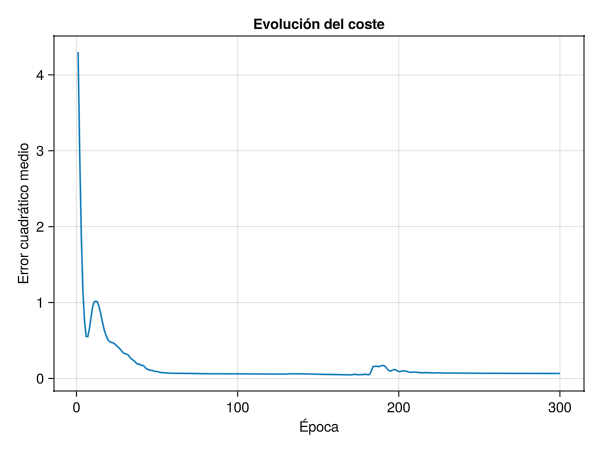

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

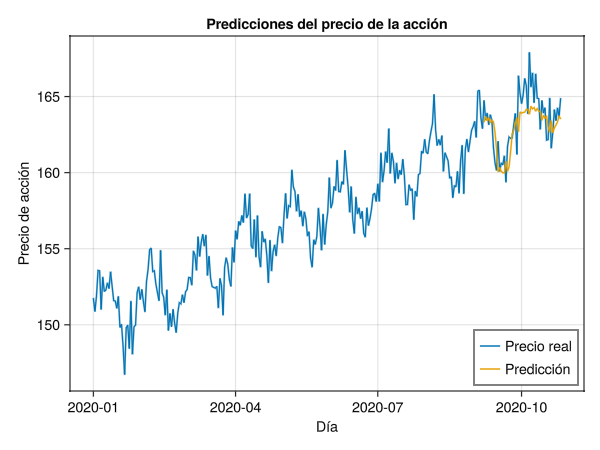

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig